In [1]:
import os
import numpy as np 
import pandas as pd
import scipy
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.chdir('/kaggle/input/BloodPressureDataset')

# ECG Features

An ECG (electrocardiogram) signal is composed of several key components inlcuding P wave, PR interval, QRS complex, ST segment and T wave. 
Distinctive spikes within the QRS complex are known as R-peaks and represent ventricular depolarization. 
The RR interval, measured as the time between consecutive R-peaks, is usually used for heart rate calculation. 
Furthermore, the variability in RR intervals, known as heart rate variability (HRV), is associated with adaptability and health of cardiovascular hsystem. 


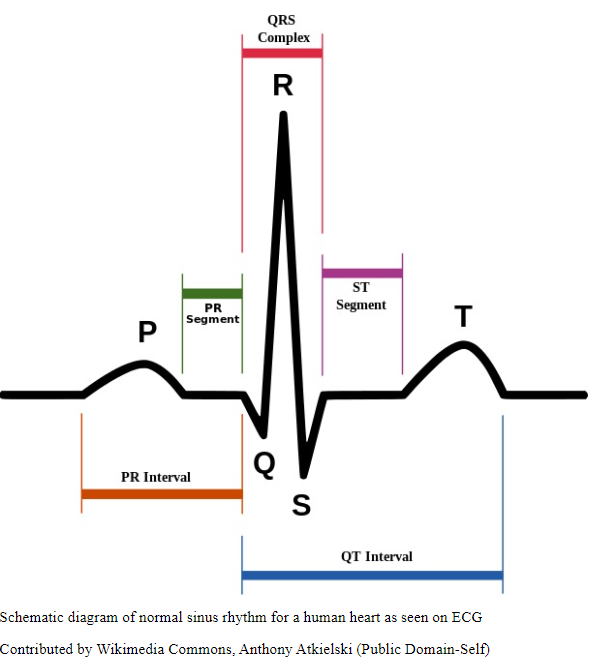

In [3]:
def detect_r_peaks_ecg(signal, sampling_rate, max_heart_rate, threshold_coef):
    """
    Detect R-peaks in an ECG signal.

    Parameters:
    - signal (array-like): ECG signal.
    - sampling_rate (int): Sampling rate of the ECG signal.
    - max_heart_rate (int): Maximum heart rate in beats per minute (bpm).
    - threshold_coef (float): Coefficient to calculate the peak detection threshold.

    Returns:
    - peaks (ndarray): Array containing the indices of R-peaks in the ECG signal.
    """
    
    # Calculate the peak detection threshold
    threshold = np.mean(signal) + threshold_coef * np.std(signal)
    
    # Calculate the minimum distance between peaks based on the maximum heart rate
    min_distance =  sampling_rate / (max_heart_rate/60)
    
    # Find R-peaks using peak detection algorithm
    peaks, _ = scipy.signal.find_peaks(signal, height=threshold, distance=min_distance)

    return np.array(peaks)

In [4]:
def find_qt_st_intervals(ecg_signal, r_peaks, sampling_rate, min_hr, max_hr, window_size):
    """
    Find the QT interval and ST segment from an ECG signal.

    Parameters:
    - ecg_signal (array-like): ECG signal.
    - r_peaks (array-like): Indices of R-peaks in the ECG signal.
    - sampling_rate (float): Sampling rate of the ECG signal.
    - max_hr (int): Maximum heart rate in beats per minute (bpm).
    - window_size (int): Size of the window for averaging.

    Returns:
    - qt_interval (float): Average QT interval in seconds.
    - st_segment (float): Average ST segment amplitude.
    """

    qt_intervals =[]
    st_segments = []
    ecg_diff = np.abs(np.diff(ecg_signal))

    # Loop through R peaks to find QT intervals and ST segments
    for i in range(len(r_peaks) - 1):
        
        r_peak_curr = r_peaks[i]
        r_peak_next = r_peaks[i + 1]
        r_peak_last = r_peaks[i - 1] if i>=1 else 0    
        
        if (r_peak_next - r_peak_curr > 60/max_hr * sampling_rate) and (r_peak_next - r_peak_curr < 60/min_hr * sampling_rate):
        
            min_index = max(r_peak_curr - int(0.1 * sampling_rate), 0)
            max_index = max(r_peak_curr + int(0.1 * sampling_rate), len(ecg_diff))
            if r_peak_curr - min_index >int(0.05 * sampling_rate):
                qrs_start_curr = np.argmin(ecg_diff[min_index : r_peak_curr- window_size]) + min_index
                qrs_end_curr = np.argmin(ecg_diff[r_peak_curr + window_size : max_index]) + r_peak_curr +5

                if r_peak_next - qrs_end_curr > int(0.1 * sampling_rate):

                    t_wave_peak = np.argmax(ecg_signal[qrs_end_curr:r_peak_next - int(0.1 * sampling_rate)]) + qrs_end_curr
                    t_wave_end = np.argmin(ecg_diff[t_wave_peak :r_peak_next]) + t_wave_peak

                    qt_interval = (t_wave_end - qrs_start_curr) / sampling_rate

                    st_segment =  ecg_signal[qrs_end_curr:t_wave_peak].mean() - ecg_signal[qrs_end_curr] if len(ecg_signal[qrs_end_curr:t_wave_peak]) > 0 else ecg_signal[t_wave_peak] - min(ecg_signal[qrs_start_curr:r_peak_next])

                    qt_intervals.append(qt_interval)
                    st_segments.append(st_segment)

    # Calculate average QT interval and ST segment
    qt_interval = np.mean(qt_intervals) if qt_intervals else 0
    st_segment = np.mean(st_segments) if st_segments else 0

    return qt_interval, st_segment

In [5]:
def extract_ecg_features(signal, sampling_rate, min_hr, max_hr, threshold_coef):
    # Detect R-peaks
    r_peaks = detect_r_peaks_ecg(signal, sampling_rate, max_hr, threshold_coef)

    # Calculate RR intervals and remove outliers 
    rr_intervals = np.diff(r_peaks)
    filtered_rr_intervals = [rr for rr in rr_intervals if rr >= (60/max_hr)*sampling_rate and rr <=(60/min_hr)*sampling_rate]

    # Calculate heart rate and RR interval variability
    if len(filtered_rr_intervals) == 0 or np.median(filtered_rr_intervals) == 0:
        heart_rate, rr_interval_variability = np.nan, np.nan
    else:
        heart_rate = 60.0 / (np.median(filtered_rr_intervals) / sampling_rate)
        rr_interval_variability = np.std(filtered_rr_intervals)/sampling_rate
        
    # Calculate QT interval and ST segment
    qt_interval, st_segment = find_qt_st_intervals(signal, r_peaks, sampling_rate, min_hr, max_hr, window_size=5)
        
    return heart_rate, rr_interval_variability, qt_interval, st_segment

# Processing Loop

In [6]:
import pandas as pd
import scipy.io

fs = 125
ecg_features_df = pd.DataFrame(columns=['m_file_id', 'id', 'HR', 'HRV', 'qt_interval', 'st_segment'])

for ii in range(12):
    
    filename = 'part_' + str(ii + 1) + '.mat'
    mat_data = scipy.io.loadmat(filename)['p']
    
    for jj in range(1000):
        ecg_signal = mat_data[0][jj][2]
        heart_rate_ecg, rr_variability, qt_interval, st_segment = extract_ecg_features(ecg_signal, fs, min_hr=40, max_hr=220, threshold_coef=2)
        
        new_row = {'m_file_id': ii, 'id': jj, 'HR': heart_rate_ecg, 'HRV': rr_variability, 'qt_interval': qt_interval, 'st_segment': st_segment}
        ecg_features_df = pd.concat([ecg_features_df, pd.DataFrame([new_row])], ignore_index=True)
        print(f"Iteration {ii+1}: {jj+1} -  HR: {np.round(heart_rate_ecg)} - QT: {np.round(qt_interval,2)} s", end='\r')


/tmp/ipykernel_26/1909698177.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ecg_features_df = pd.concat([ecg_features_df, pd.DataFrame([new_row])], ignore_index=True)


# Heart Rate

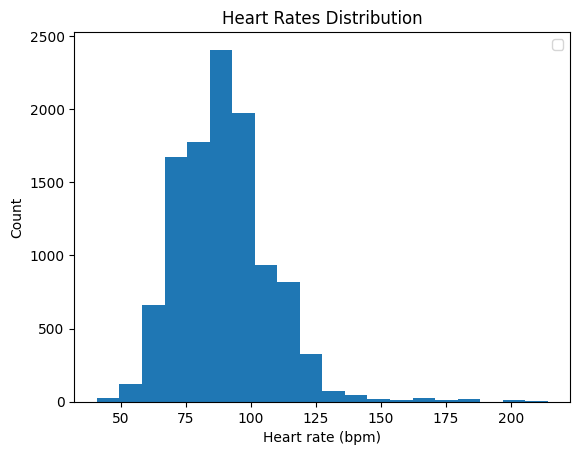

In [7]:
plt.hist(ecg_features_df['HR'], bins=20)
plt.title('Heart Rates Distribution')
plt.xlabel('Heart rate (bpm)')
plt.ylabel('Count')
plt.legend()

# Heart Rate Variability (HRV) 

Text(0, 0.5, 'Count')

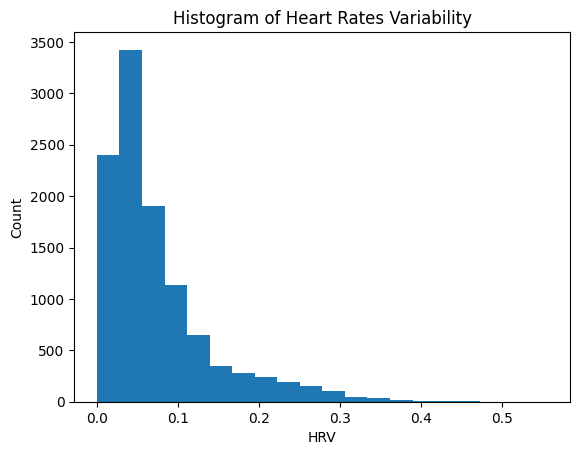

In [8]:
plt.hist(ecg_features_df['HRV'], bins= 20)
plt.title('Histogram of Heart Rates Variability')
plt.xlabel('HRV')
plt.ylabel('Count')


# QT interval

Text(0, 0.5, 'Count')

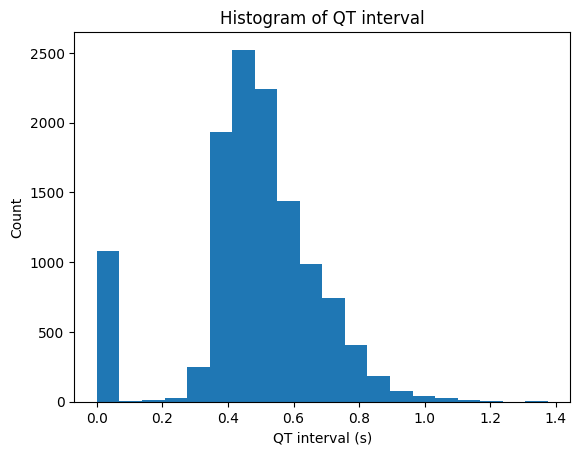

In [9]:
plt.hist(ecg_features_df['qt_interval'], bins =20)
plt.title('Histogram of QT interval')
plt.xlabel('QT interval (s)')
plt.ylabel('Count')

Text(29.140624999999993, 0.5, 'QT interval (s)')

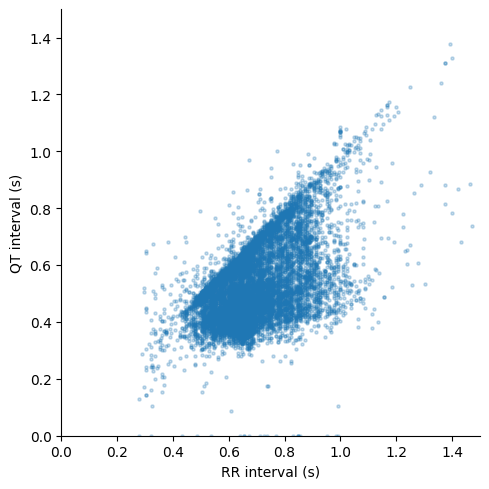

In [10]:
ecg_features_df['rr_interval'] = 60/ecg_features_df['HR']
sns.lmplot(data=ecg_features_df, x='rr_interval', y='qt_interval', fit_reg=False, scatter_kws={'alpha': 0.25, 's':5})
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.xlabel('RR interval (s)')
plt.ylabel('QT interval (s)')

#  ST segment

Text(0, 0.5, 'Count')

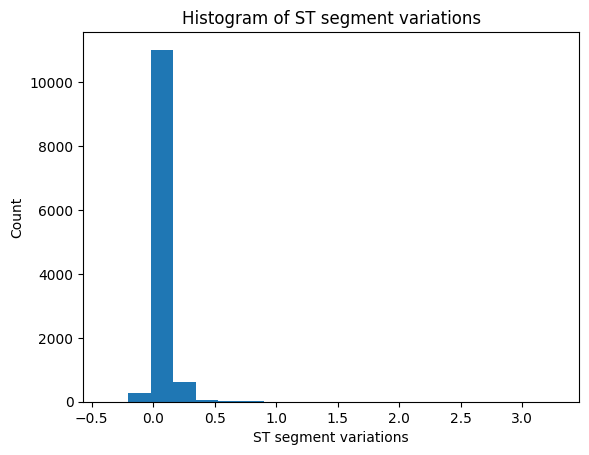

In [11]:
plt.hist(ecg_features_df['st_segment'], bins= 20)
plt.title('Histogram of ST segment variations')
plt.xlabel('ST segment variations')
plt.ylabel('Count')

In [12]:
os.chdir("/kaggle/working")
ecg_features_df.to_csv('ecg_features.csv', index=False)